In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.fft import fft, fftfreq

# 1. Read audio

In [2]:
# Đọc tệp âm thanh .wav từ file đã tải lên
file_path = '../data/i.wav'
data, sampling_rate = librosa.load(file_path, sr=None)

In [3]:
# Nếu là âm thanh stereo, chuyển sang mono (chỉ lấy một kênh)
if len(data.shape) == 2:
    data = data.mean(axis=1)

# 2. Remove silent frames

In [4]:
def remove_silent_frames(data: np.ndarray, threshold=0.005, frame_length=30, hop_size=15) -> np.ndarray:
    # Tính RMSE
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_size, center=True)

    # Tạo danh sách các frame mà RMSE >= ngưỡng
    valid_frames = np.where(rmse[0] >= threshold)[0]

    # Nếu không có frame nào thỏa mãn, trả về mảng trống
    if len(valid_frames) == 0:
        return []

    # Tính các chỉ số sample tương ứng với các frame đầu và cuối hợp lệ
    start_sample_index = librosa.frames_to_samples(valid_frames[0], hop_length=hop_size)
    end_sample_index = librosa.frames_to_samples(valid_frames[-1] + 1, hop_length=hop_size)

    print(f"Start sample index: {start_sample_index}")
    print(f"End sample index: {end_sample_index}")

    # Trả về đoạn âm thanh sau khi loại bỏ các frame không hợp lệ
    return data[start_sample_index:end_sample_index]

In [5]:
signal_segment = remove_silent_frames(data)

Start sample index: 7635
End sample index: 14085


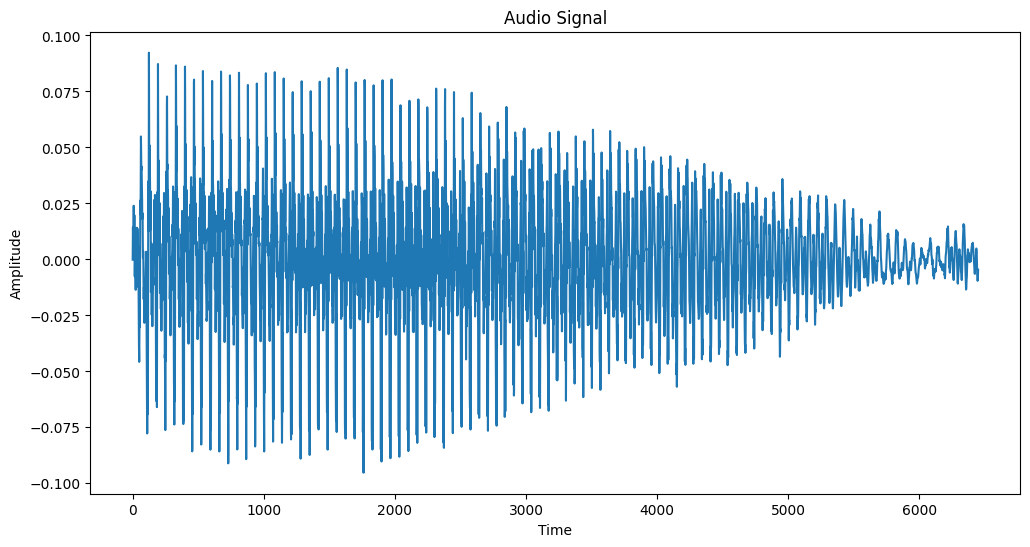

In [6]:
# Plot tín hiệu âm thanh
plt.figure(figsize=(12, 6))
plt.plot(signal_segment)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Audio Signal')
plt.show()

# 3. Find F0 using FFT

In [7]:
# Lấy đoạn tín hiệu từ start_sample đến end_sample
N = len(signal_segment)
T = 1.0 / sampling_rate
t = np.linspace(0.0, N*T, N, endpoint=False)

In [8]:
# Áp dụng biến đổi Fourier nhanh (FFT) cho đoạn đã chọn
yf = fft(signal_segment)
xf = fftfreq(N, T)[:N//2]

# Lấy giá trị phổ biên độ của FFT (giá trị thực)
amplitude_spectrum = 2.0/N * np.abs(yf[0:N//2])

### Biên độ của phổ tần số cho biết cường độ của các thành phần tần số có mặt trong tín hiệu, giúp ta hiểu được thành phần nào chiếm ưu thế và đóng góp vào hình dạng tổng quát của tín hiệu.

In [9]:
# Tìm các chỉ số của top 5 đỉnh cao nhất
top_5_peaks_indices = np.argsort(amplitude_spectrum)[-5:][::-1]  # Sắp xếp và chọn 5 đỉnh lớn nhất

# Tần số F0 ứng với chỉ số lớn nhất (đỉnh đầu tiên)
f0_top_5 = xf[top_5_peaks_indices]
amplitude_top_5 = amplitude_spectrum[top_5_peaks_indices]

# In top 5 tần số và biên độ tương ứng
for i, (f0, amplitude) in enumerate(zip(f0_top_5, amplitude_top_5), start=1):
    print(f"Đỉnh {i}: F0 = {f0:.2f} Hz, Biên độ = {amplitude:.4f}")

Đỉnh 1: F0 = 468.84 Hz, Biên độ = 0.0100
Đỉnh 2: F0 = 466.36 Hz, Biên độ = 0.0096
Đỉnh 3: F0 = 235.66 Hz, Biên độ = 0.0082
Đỉnh 4: F0 = 478.76 Hz, Biên độ = 0.0078
Đỉnh 5: F0 = 486.20 Hz, Biên độ = 0.0076


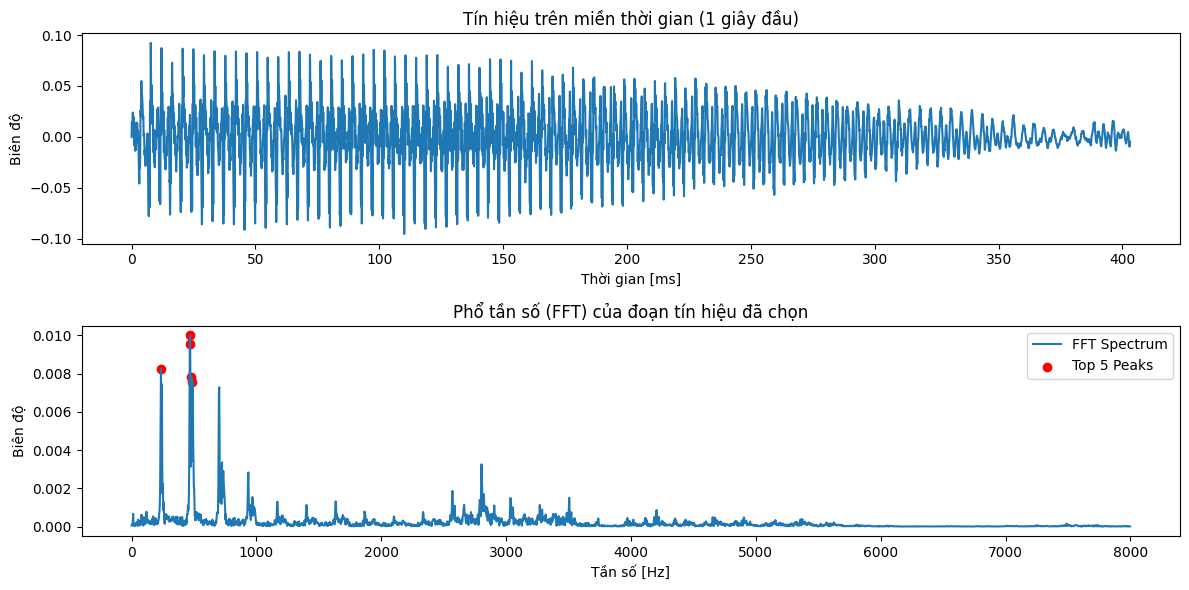

In [10]:
# Vẽ tín hiệu và phổ tần số cho đoạn đã chọn
plt.figure(figsize=(12, 6))

# Vẽ tín hiệu trên miền thời gian (chuyển từ giây sang mili giây)
plt.subplot(2, 1, 1)
plt.plot(t * 1000, signal_segment)  # Chuyển đổi thời gian sang ms
plt.title('Tín hiệu trên miền thời gian (1 giây đầu)')
plt.xlabel('Thời gian [ms]')
plt.ylabel('Biên độ')

# Vẽ phổ tần số
plt.subplot(2, 1, 2)
plt.plot(xf, amplitude_spectrum, label='FFT Spectrum')
plt.scatter(f0_top_5, amplitude_top_5, color='r', label='Top 5 Peaks')  # Đánh dấu top 5 đỉnh
plt.title('Phổ tần số (FFT) của đoạn tín hiệu đã chọn')
plt.xlabel('Tần số [Hz]')
plt.ylabel('Biên độ')

plt.legend()
plt.tight_layout()
plt.show()